# Part 1: Preparing data and linear classification

In [58]:
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Reading test and train data

In [44]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [45]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
y_train = train["label"]

x_train = train.drop(labels = ["label"],axis = 1)

In [48]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Normalize data

In [49]:
x_train = x_train / 255.0

test = test / 255.0

Let's look at the data

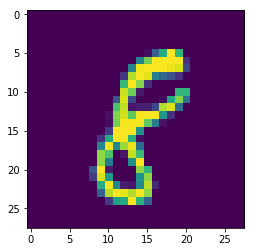

In [40]:
plt.imshow(x_train[0][:, :, 0])

Split on train and validation classes

In [51]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=42)

Let's try to classify digits with usual method of machine learning.

Choose the best parameters

In [65]:
parameters = {'C':[1, 10]}
linear_clf = LinearSVC()

opt_linear_clf = GridSearchCV(linear_clf, parameters, cv=5, scoring='accuracy')
opt_linear_clf.fit(x_train, y_train)

print("Best params:", opt_linear_clf.best_params_)

Best params: {'C': 1}


In [66]:
prediction = opt_linear_clf.predict(x_val)
linear_result = accuracy_score(y_val, prediction)

print('Result accuracy:', linear_result)

Result accuracy: 0.9078571428571428


# Part 2: non-linear classification

We will use random forest to improve our result

In [ ]:
parameters = {'n_estimators': [100, 200, 500]}
rf_clf = RandomForestClassifier()

opt_rf_clf = GridSearchCV(rf_clf, parameters, cv=5, scoring='accuracy')
opt_rf_clf.fit(x_train, y_train)

print("Best params:", opt_rf_clf.best_params_)

In [ ]:
prediction = opt_rf_clf.predict(x_val)
rf_result = accuracy_score(y_val, prediction)

print('Result accuracy:', rf_result)